# Time Series Anomaly Detection using LSTM Autoencoders with PyTorch in Python

**Anomaly Classification using CNN**

In [2]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 49.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 9.7 MB/s eta 0:00:00


In [3]:
!pip install mcfly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.0 MB/s eta 0:00:0000:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [54]:
import os
import sys
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from collections import Counter
from sktime.datatypes import convert_to
from timeit import default_timer as timer
from sktime.datasets import load_from_tsfile
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from mcfly.modelgen import generate_models
from mcfly.find_architecture import find_best_architecture
from mcfly.find_architecture import train_models_on_samples
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import load_model

warnings.filterwarnings('ignore')
np.random.seed(42)

In [27]:
X = np.swapaxes(X, 1, 2)
X.shape

(2792, 17, 40)

In [100]:
# no rolling stats
X = np.load('/kaggle/input/alafa-dataset-60/ALFA_seq_dataset_5_class_windows_60/alfa_dataset_sequence_X_windows_60.npy')
y = np.load('/kaggle/input/alafa-dataset-60/ALFA_seq_dataset_5_class_windows_60/alfa_dataset_sequence_y_windows_60.npy')
print(X.shape)
print(y.shape)

(2573, 60, 17)
(2573,)


In [101]:
mean = np.mean(X, axis=(0, 1), keepdims=True)
std = np.std(X, axis=(0, 1), keepdims=True)

# Z-score normalize the array
X = (X - mean) / std

In [102]:
ohe = OneHotEncoder()

y = ohe.fit_transform(y.reshape(-1, 1)).toarray()
y.shape

(2573, 2)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20, random_state=42,
                                                    shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.20, random_state=42,
                                                  shuffle=True, stratify=y_train)


print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1646, 60, 17) (412, 60, 17) (515, 60, 17)
(1646, 2) (412, 2) (515, 2)


In [104]:
class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(np.argmax(y, axis=1)),
    y = np.argmax(y, axis=1)
)

class_weights = dict(zip(np.unique(np.argmax(y, axis=1)), class_weights))
class_weights

{0: 0.5221185064935064, 1: 11.802752293577981}

In [78]:
!pwd

/kaggle/working


In [105]:
os.makedirs(os.path.join(os.getcwd(),"models"),exist_ok=True)

In [106]:
model_path = os.path.join(os.getcwd(), "models")
model_path

'/kaggle/working/models'

In [129]:
%%time

file_name = f"model-comparison-20220808.json"
output_file = os.path.join(model_path, file_name)
model_path = model_path

metric_key = "pr_auc"
metric = AUC(curve="PR", name=metric_key )

# metric_key = "accuracy"
# metric = "accuracy"

models = generate_models(
    X_train.shape,
    y_train.shape[1],
    number_of_models=3,
    model_types = ['DeepConvLSTM'],
    #model_types=['CNN', 'ResNet', 'InceptionTime'],
    metrics=[metric]
)

history, val_metrics, val_losses = train_models_on_samples(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    models=models,
    nr_epochs=30,
    verbose=True,
    model_path=model_path,
    outputfile=output_file,
    subset_size=int(X_train.shape[0] / 2),
    class_weight=class_weights
)

Generated models will be trained on subset of the data (subset size: 823).
Training model 0 DeepConvLSTM
Epoch 1/30
42/42 [==============================] - 9s 41ms/step - loss: 1.1046 - pr_auc: 0.6891 - val_loss: 0.9264 - val_pr_auc: 0.7695
Epoch 2/30
42/42 [==============================] - 1s 14ms/step - loss: 1.0085 - pr_auc: 0.6859 - val_loss: 0.8393 - val_pr_auc: 0.8380
Epoch 3/30
42/42 [==============================] - 1s 14ms/step - loss: 0.9162 - pr_auc: 0.7674 - val_loss: 0.8422 - val_pr_auc: 0.8089
Epoch 4/30
42/42 [==============================] - 1s 14ms/step - loss: 0.8109 - pr_auc: 0.8222 - val_loss: 0.8917 - val_pr_auc: 0.7734
Epoch 5/30
42/42 [==============================] - 1s 14ms/step - loss: 0.6936 - pr_auc: 0.9052 - val_loss: 0.9407 - val_pr_auc: 0.7356
Epoch 5: early stopping
Training model 1 DeepConvLSTM
Epoch 1/30
42/42 [==============================] - 6s 34ms/step - loss: 0.9216 - pr_auc: 0.7158 - val_loss: 0.6036 - val_pr_auc: 0.9188
Epoch 2/30
42/42 [=

In [130]:
best_model_index = np.argmax(val_metrics[metric_key])
#best_model, best_params, best_model_type = models[best_model_index]
best_model, best_params, best_model_type = models[0]

print(best_model_index)
print("Best model type:", best_model_type)

2
Best model type: DeepConvLSTM


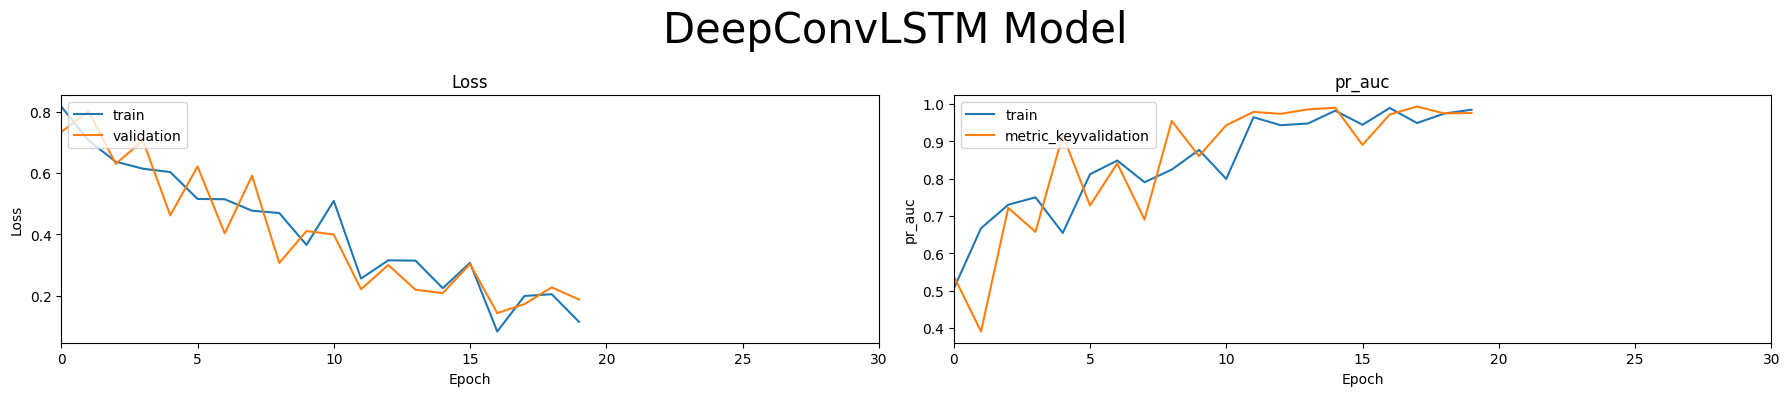

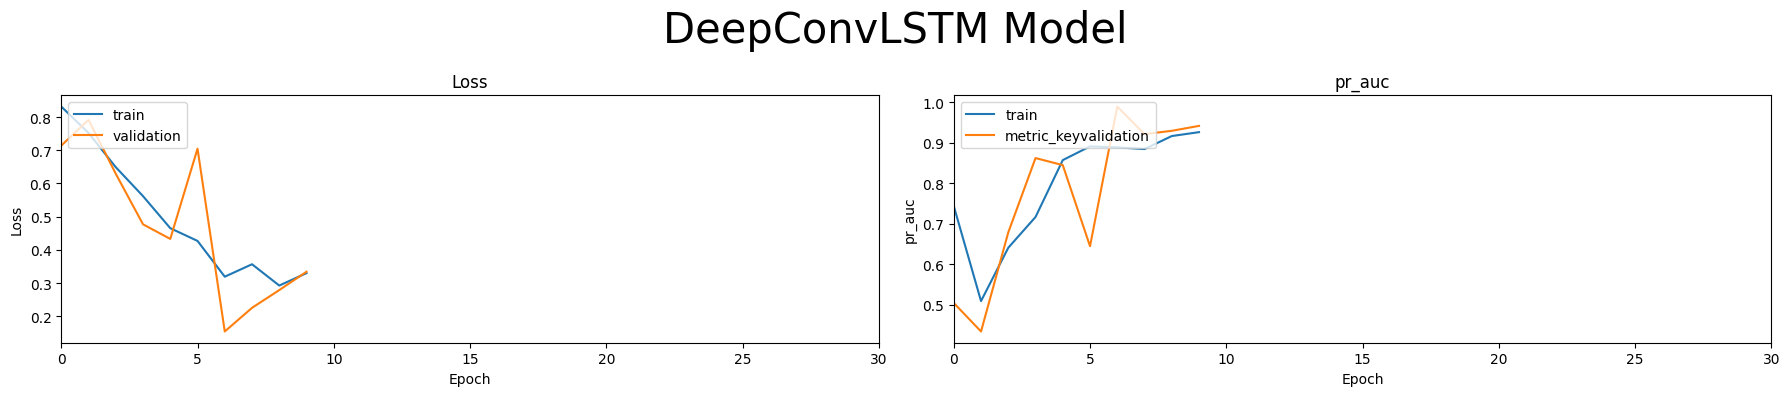

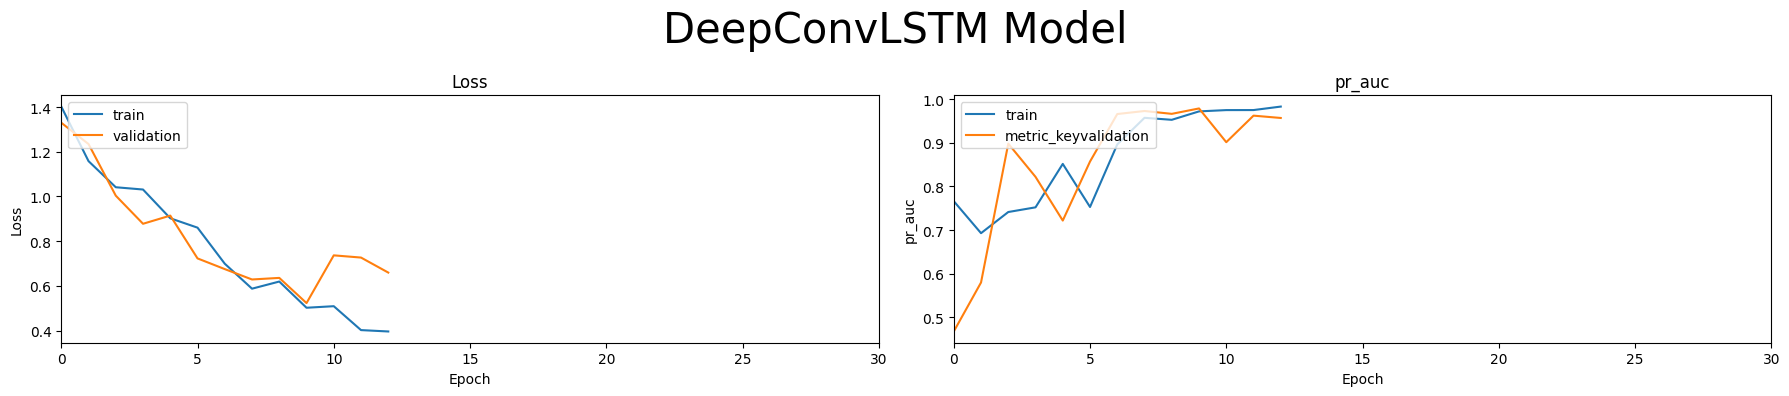

In [111]:
model_types = list(map(lambda m: m[2],models))

for i in range(len(model_types)):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 4))

    fig.suptitle(f"{model_types[i]} Model", fontsize=30)

    ax1.plot(history[i].history['loss'])
    ax1.plot(history[i].history['val_loss'])
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_xlim([0, 30])
    ax1.legend(['train', 'validation'], loc='upper left')

    ax2.plot(history[i].history[metric_key])
    ax2.plot(history[i].history[f'val_{metric_key}'])
    ax2.set_title(metric_key)
    ax2.set_ylabel(metric_key)
    ax2.set_xlabel('Epoch')
    ax2.set_xlim([0, 30])
    ax2.legend(['train', 'metric_keyvalidation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [132]:
%%time

history = best_model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_val, y_val),
)

Epoch 1/10
52/52 [==============================] - 1s 16ms/step - loss: 0.1435 - pr_auc: 0.9982 - val_loss: 0.1498 - val_pr_auc: 0.9994
Epoch 2/10
52/52 [==============================] - 1s 14ms/step - loss: 0.1370 - pr_auc: 0.9992 - val_loss: 0.1339 - val_pr_auc: 0.9994
Epoch 3/10
52/52 [==============================] - 1s 15ms/step - loss: 0.1289 - pr_auc: 0.9994 - val_loss: 0.2767 - val_pr_auc: 0.9763
Epoch 4/10
52/52 [==============================] - 1s 15ms/step - loss: 0.1362 - pr_auc: 0.9987 - val_loss: 0.1530 - val_pr_auc: 0.9984
Epoch 5/10
52/52 [==============================] - 1s 14ms/step - loss: 0.1175 - pr_auc: 0.9996 - val_loss: 0.1163 - val_pr_auc: 0.9996
Epoch 6/10
52/52 [==============================] - 1s 15ms/step - loss: 0.1307 - pr_auc: 0.9973 - val_loss: 0.1479 - val_pr_auc: 0.9985
Epoch 7/10
52/52 [==============================] - 1s 14ms/step - loss: 0.1274 - pr_auc: 0.9990 - val_loss: 0.1537 - val_pr_auc: 0.9984
Epoch 8/10
52/52 [=======================

In [67]:
y_test.shape

(515, 2)

In [133]:
import time

t = time.time()
y_pred = best_model.predict(X_test, batch_size=1)
print(time.time() - t)

515/515 [==============================] - 2s 3ms/step
2.7079145908355713


In [134]:
print(f"Classification report fot the {best_model_type} model:\n")
print(
    classification_report(
        np.argmax(y_test, axis=1),
        np.argmax(y_pred, axis=1),
        digits=4
    )
)

Classification report fot the DeepConvLSTM model:

              precision    recall  f1-score   support

           0     0.9821    1.0000    0.9910       493
           1     1.0000    0.5909    0.7429        22

    accuracy                         0.9825       515
   macro avg     0.9910    0.7955    0.8669       515
weighted avg     0.9828    0.9825    0.9804       515



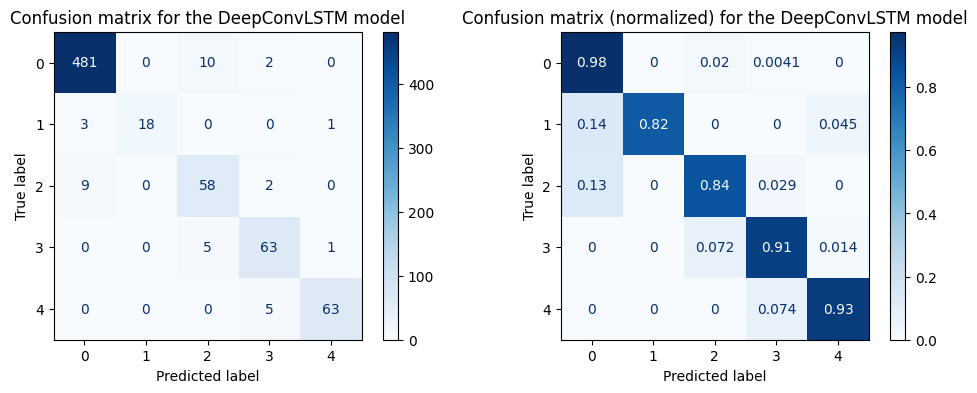

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize=None,
    cmap="Blues",
    ax=ax1
)

ax1.set_title(f"Confusion matrix for the {best_model_type} model")

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize="true",
    cmap="Blues",
    ax=ax2
)

ax2.set_title(f"Confusion matrix (normalized) for the {best_model_type} model")

plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
==================================================================================================
 input_1 (InputLayer)        [(None, 40, 17)]             0         []                            
                                                                                                  
 batch_normalization_9 (Bat  (None, 40, 17)               68        ['input_1[0][0]']             
 chNormalization)                                                                                 
                                                                                                  
 conv1d_7 (Conv1D)           (None, 40, 69)               10626     ['batch_normalization_9[0][0]'
                                                                    ]                             
                                                                                                  
 batch_normalization_10 (Ba  (None, 40, 69)               276       ['conv1d_7[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 re_lu (ReLU)                (None, 40, 69)               0         ['batch_normalization_10[0][0]
                                                                    ']                            
                                                                                                  
 conv1d_8 (Conv1D)           (None, 40, 69)               42918     ['re_lu[0][0]']               
                                                                                                  
 batch_normalization_11 (Ba  (None, 40, 69)               276       ['conv1d_8[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 re_lu_1 (ReLU)              (None, 40, 69)               0         ['batch_normalization_11[0][0]
                                                                    ']                            
                                                                                                  
 conv1d_9 (Conv1D)           (None, 40, 69)               42918     ['re_lu_1[0][0]']             
                                                                                                  
 batch_normalization_12 (Ba  (None, 40, 69)               276       ['conv1d_9[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 re_lu_2 (ReLU)              (None, 40, 69)               0         ['batch_normalization_12[0][0]
                                                                    ']                            
                                                                                                  
 conv1d_10 (Conv1D)          (None, 40, 69)               4830      ['re_lu_2[0][0]']             
                                                                                                  
 add (Add)                   (None, 40, 69)               0         ['re_lu_2[0][0]',             
                                                                     'conv1d_10[0][0]']           
                                                                                                  
 conv1d_11 (Conv1D)          (None, 40, 97)               40255     ['add[0][0]']                 
                                                                                                  
 batch_normalization_13 (Ba  (None, 40, 97)               388       ['conv1d_11[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_3 (ReLU)              (None, 40, 97)               0         ['batch_normalization_13[0][0]
                                                                    ']                            
                                                                                                  
 conv1d_12 (Conv1D)          (None, 40, 97)               56551     ['re_lu_3[0][0]']             
                                                                                                  
 batch_normalization_14 (Ba  (None, 40, 97)               388       ['conv1d_12[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_4 (ReLU)              (None, 40, 97)               0         ['batch_normalization_14[0][0]
                                                                    ']                            
                                                                                                  
 conv1d_13 (Conv1D)          (None, 40, 97)               56551     ['re_lu_4[0][0]']             
                                                                                                  
 batch_normalization_15 (Ba  (None, 40, 97)               388       ['conv1d_13[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_5 (ReLU)              (None, 40, 97)               0         ['batch_normalization_15[0][0]
                                                                    ']                            
                                                                                                  
 conv1d_14 (Conv1D)          (None, 40, 97)               9506      ['re_lu_5[0][0]']             
                                                                                                  
 add_1 (Add)                 (None, 40, 97)               0         ['re_lu_5[0][0]',             
                                                                     'conv1d_14[0][0]']           
                                                                                                  
 conv1d_15 (Conv1D)          (None, 40, 137)              53293     ['add_1[0][0]']               
                                                                                                  
 batch_normalization_16 (Ba  (None, 40, 137)              548       ['conv1d_15[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_6 (ReLU)              (None, 40, 137)              0         ['batch_normalization_16[0][0]
                                                                    ']                            
                                                                                                  
 conv1d_16 (Conv1D)          (None, 40, 137)              75213     ['re_lu_6[0][0]']             
                                                                                                  
 batch_normalization_17 (Ba  (None, 40, 137)              548       ['conv1d_16[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_7 (ReLU)              (None, 40, 137)              0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 conv1d_17 (Conv1D)          (None, 40, 137)              75213     ['re_lu_7[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 40, 137)              548       ['conv1d_17[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_8 (ReLU)              (None, 40, 137)              0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 conv1d_18 (Conv1D)          (None, 40, 137)              18906     ['re_lu_8[0][0]']             
                                                                                                  
 add_2 (Add)                 (None, 40, 137)              0         ['re_lu_8[0][0]',             
                                                                     'conv1d_18[0][0]']           
                                                                                                  
 global_average_pooling1d (  (None, 137)                  0         ['add_2[0][0]']               
 GlobalAveragePooling1D)                                                                          
                                                                                                  
 dense_2 (Dense)             (None, 2)                    276       ['global_average_pooling1d[0][
                                                                    0]']                          
                                                                                                  
 activation_9 (Activation)   (None, 2)                    0         ['dense_2[0][0]']             
                                                                                                  
==================================================================================================
Total params: 490760 (1.87 MB)
Trainable params: 488908 (1.87 MB)
Non-trainable params: 1852 (7.23 KB)
__________________________________________________________________________________________________
[ ]
12345678910111213141516171819202122232425


In [ ]:
from keras.models import load_model
model = load_model('/content/models/model_3.h5')
model.summary()

Model: "model_9"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 input_10 (InputLayer)       [(None, 40, 17)]             0         []                            

                                                                                                  

 batch_normalization_112 (B  (None, 40, 17)               68        ['input_10[0][0]']            

 atchNormalization)                                                                               

                                                                                                  

 conv1d_188 (Conv1D)         (None, 40, 32)               544       ['batch_normalization_112[0][0

                                                                    ]']                           

                                                                                 